In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from dagmm_1dcnn import DAGMM

import matplotlib.pyplot as plt
%matplotlib inline

/media/project_workspace/baiyong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cnv_data_dir = '../cnv_data/'
model_dir = './ws10000_bins20_ERR009342_1_15cov_1dcnn'

In [3]:
sample_id_arr = np.loadtxt(os.path.join(cnv_data_dir,'sample.list'), 
                        delimiter='\t',usecols=(0,1),dtype='str')

sample_id_dict=dict(zip(sample_id_arr[:,1],sample_id_arr[:,0]))

In [4]:
colors={0:'r', 1:'g', 2: 'b', 3:'y',4:'k',5:'m',6:'c'}

model_dagmm = DAGMM(
    est_hiddens=[8,3], est_activation=tf.nn.relu, est_dropout_ratio=0.25,
    epoch_size=100, minibatch_size=1024 #1000
)
model_dagmm.restore(model_dir)

INFO:tensorflow:Restoring parameters from ./ws10000_bins20_ERR009342_1_15cov_1dcnn/DAGMM_model


In [5]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [6]:
# only for somactic DNA
# chrs = ['chr'+str(i) for i in range(1,23)] 
chrs = ['chr1'] 

In [7]:
# NA12878 to test 
# deepest 
#[ 'SRR035311_1.sorted.rmdup.realign.BQSR.bam.correct_ratio.txt',
# 'SRR069520_1.sorted.rmdup.realign.BQSR.bam.correct_ratio.txt',
# 'SRR069534_1.sorted.rmdup.realign.BQSR.bam.correct_ratio.txt',
# 'SRR098401_1.sorted.rmdup.realign.BQSR.bam.correct_ratio.txt',
# 'SRR359295_1.sorted.rmdup.realign.BQSR.bam.correct_ratio.txt',
# 'SRR393035_1.sorted.rmdup.realign.BQSR.bam.correct_ratio.txt']

# SRR098401_1是NA12878
idd = 'ERR022452_1'
test_fname = '15coverage_ws10000_ratio/'+idd+'.sorted.rmdup.realign.BQSR.bam.HG01136_winsize_10000.correct_ratio.txt'
#test_fname = '10_sample_corrected_copy_result/ERR055395_1.sorted.rmdup.realign.BQSR.bam.NA21137_winsize_1000.wig.correct_ratio.txt'
test_df =pd.read_csv(os.path.join(cnv_data_dir,test_fname), sep='\t')


In [8]:
win_size=[10,15,20,30,50]
ws = win_size[2]

cy_ratio_mat=[]
for chrn in chrs:
    chr_df = test_df[(test_df['space']==chrn) & (test_df['copy'])].sort_values(by=['start'])
    i_copy = chr_df['copy'].values
    # add 0 at the beginning of sequence
    tmp_copy = np.append([0]*(ws-1),i_copy)
    i_cy_matrix= rolling_window(tmp_copy,ws)
    if len(cy_ratio_mat) == 0:
        cy_ratio_mat = i_cy_matrix
    else:
        cy_ratio_mat = np.concatenate((cy_ratio_mat,i_cy_matrix),axis=0)

start_pos=chr_df['start'].values


(0, 500)

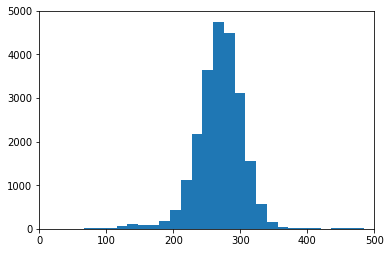

In [9]:
plt.hist(chr_df['reads'].values,bins=5000)
plt.xlim([0,500])

Text(0.5,1,'HG01136,chr1')

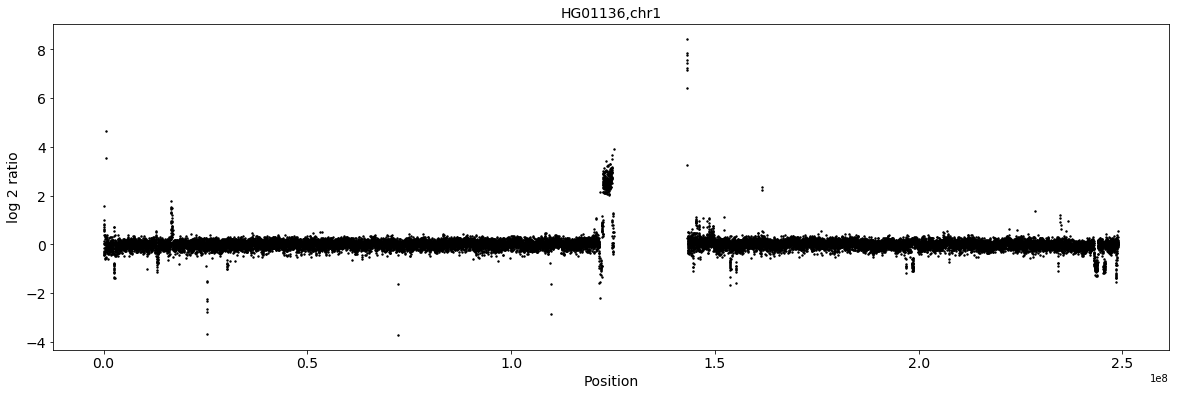

In [10]:
plt.figure(figsize=(20,6))
plt.scatter(start_pos,i_copy,s=2,c='k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position',fontsize=14)
plt.ylabel('log 2 ratio',fontsize=14)
plt.title('HG01136,chr1',fontsize=14)

# Prediction

In [11]:
from scipy.special import logsumexp

energy,logit_probs = model_dagmm.predict(cy_ratio_mat)
lse = logsumexp(logit_probs,axis=0)
log_resp=logit_probs-lse[np.newaxis,:]
comp_prob = np.exp(log_resp)
i_comp=np.argmax(comp_prob,axis=0)

In [12]:
cnvs_annos = pd.read_csv(os.path.join(cnv_data_dir,'ALL.wgs.mergedSV.v8.20130502.svs.genotypes.GRCh38.vcf.cnvs.dat'),
           sep='\t',usecols=['CHROM', 'POS', 'ID', 'ALT', 'SVTYPE',
       'SVLEN', 'END', 'SUPP_N_HET','SUPP_N_HOM_ALT','SUPP_HETS','SUPP_HOM_ALTS'])


/media/project_workspace/baiyong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
sampleId = sample_id_dict[idd]
test_cnvs = cnvs_annos[cnvs_annos['SUPP_HETS'].str.contains(sampleId) 
                          | cnvs_annos['SUPP_HOM_ALTS'].str.contains(sampleId)]

test_cnvs.sort_values(by=['CHROM','POS'],inplace=True)

/media/project_workspace/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [14]:
sampleId

'HG01136'

In [15]:
test_cnvs.head()

,CHROM,POS,ID,ALT,SVTYPE,SVLEN,END,SUPP_N_HET,SUPP_N_HOM_ALT,SUPP_HETS,SUPP_HOM_ALTS
15,1,1207334,UW_VH_1989,<CN0>,DEL,426.0,1207760.0,636,283,"HG00111,0|1;HG00115,1|0;HG00116,1|0;HG00118,1|...","HG00128,1|1;HG00275,1|1;HG00328,1|1;HG00384,1|..."
66,1,3181807,DEL_pindel_98,C,DEL,118.0,3181925.0,595,1,"HG00097,0|1;HG00099,0|1;HG00101,0|1;HG00102,1|...","HG02851,1|1"
99,1,4428062,DEL_pindel_141,C,DEL,100.0,4428162.0,268,0,"HG00190,0|1;HG00362,0|1;HG00368,1|0;HG00376,1|...",NaN
215,1,10422442,UW_VH_0,<CN0>,DEL,1291.0,10423733.0,1041,304,"HG00096,1|0;HG00099,0|1;HG00100,1|0;HG00105,0|...","HG00102,1|1;HG00114,1|1;HG00118,1|1;HG00126,1|..."
233,1,11622816,UW_VH_58,<CN0>,DEL,316.0,11623132.0,1090,721,"HG00096,0|1;HG00099,0|1;HG00105,1|0;HG00107,0|...","HG00097,1|1;HG00100,1|1;HG00101,1|1;HG00102,1|..."


In [16]:
test_cnvss = test_cnvs[test_cnvs['CHROM']==1]

In [17]:
test_cnvs_starts = test_cnvss['POS'].values//10000 * 10000+1
test_cnvs_ends = np.ceil(test_cnvss['END'].values/10000) * 10000+1
test_cnvs_ends = test_cnvs_ends.astype('int')
test_cnvs_labs = [ -3 if x=='DEL' else 3 if x=='DUP' else 2  for x in test_cnvss['SVTYPE'].values]


In [18]:
com_item = set(start_pos).intersection(test_cnvs_ends)
start_pos_ind = [list(start_pos).index(int(x)) for x in com_item]


In [19]:
np.unique(i_comp)

array([0, 1, 2])

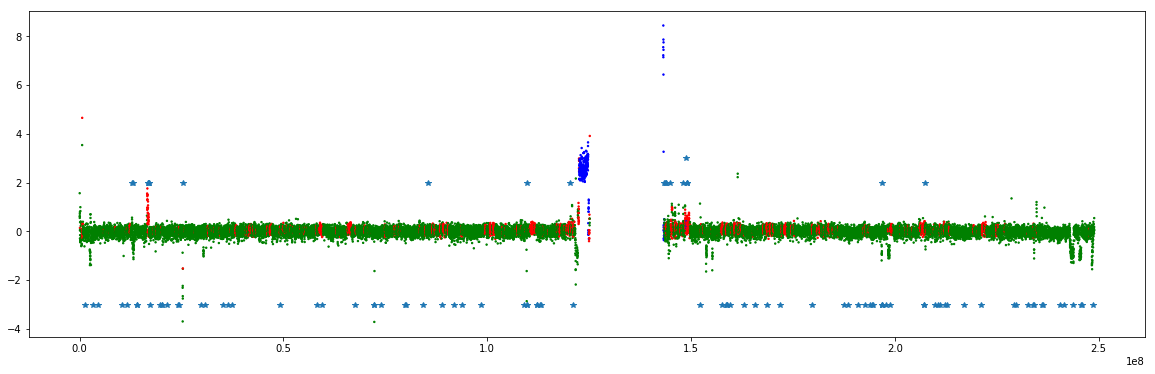

In [20]:
# bins=20
import matplotlib.pyplot as plt
%matplotlib inline

color = [colors[x] for x in i_comp]
plt.figure(figsize=(20,6))

plt.scatter(start_pos,i_copy,c=color,s=2)
#plt.hlines(y=test_cnvs_labs,xmin=test_cnvs_starts,xmax=test_cnvs_ends)
plt.plot(test_cnvs_starts,test_cnvs_labs,'*')